# Going Deeper(CV)
# 6. 이미지 어디까지 우려볼까? [프로젝트]

## 6-1. 프로젝트: CutMix 또는 Mixup 비교실험 하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/Going_deeper

Mounted at /content/drive
/content/drive/MyDrive/aiffel/Going_deeper


In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.12.0
1.22.4


In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation을 적용한 데이터셋 만들기

In [5]:
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)

    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)

    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :]
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)

    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [7]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalizer_on_dataset(ds, is_test=False, batch_size=16,
                                with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalizer_on_dataset(ds_train, with_aug=False) # 원래 훈련 데이터
ds_train_aug = apply_normalizer_on_dataset(ds_train, with_aug=True) # 기본적인 Augmentation 적용
ds_train_aug_cutmix = apply_normalizer_on_dataset(ds_train, with_aug=True, with_cutmix=True)    # 기본 + CutMix 적용
ds_train_aug_mixup = apply_normalizer_on_dataset(ds_train, with_aug=True, with_mixup=True)  # 기본 + Mixup 적용
ds_test = apply_normalizer_on_dataset(ds_test, is_test=True)    # 테스트 데이터

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete2YDYYX/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete2YDYYX/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### 2. 모델 만들기

In [ ]:
# augmentation 미사용 모델
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
# augmentation 사용 모델
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 3. 모델 훈련하기

아래 훈련 기록이 없는 모델들은 다른 커널에서 동시에 학습을 진행하여 결과 history를 pickle로 가져왔기 때문에 그렇습니다.

In [ ]:
# No Augmentation
import pickle

EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch20/history_resnet50_no_aug.pickle', 'wb') as file:
    pickle.dump(history_resnet50_no_aug.history, file)

Epoch 1/20
750/750 [==============================] - 208s 231ms/step - loss: 2.1798 - accuracy: 0.4549 - val_loss: 3.6241 - val_accuracy: 0.1810
Epoch 2/20
750/750 [==============================] - 173s 231ms/step - loss: 0.7462 - accuracy: 0.7948 - val_loss: 1.0511 - val_accuracy: 0.6919
Epoch 3/20
750/750 [==============================] - 174s 232ms/step - loss: 0.2684 - accuracy: 0.9377 - val_loss: 0.9475 - val_accuracy: 0.7203
Epoch 4/20
750/750 [==============================] - 175s 234ms/step - loss: 0.0822 - accuracy: 0.9906 - val_loss: 0.9646 - val_accuracy: 0.7310
Epoch 5/20
750/750 [==============================] - 161s 214ms/step - loss: 0.0370 - accuracy: 0.9980 - val_loss: 0.9138 - val_accuracy: 0.7453
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0262 - accuracy: 0.9988 - val_loss: 0.9164 - val_accuracy: 0.7471
Epoch 7/20
750/750 [==============================] - 173s 231ms/step - loss: 0.0123 - accuracy: 0.9996 - val_loss: 0.9212 -

In [ ]:
# 기본 + CutMix 적용
import pickle

EPOCH = 20

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch20/history_resnet50_aug_cutmix.pickle', 'wb') as file:
    pickle.dump(history_resnet50_aug_cutmix.history, file)

### 4. 훈련 과정 시각화하기

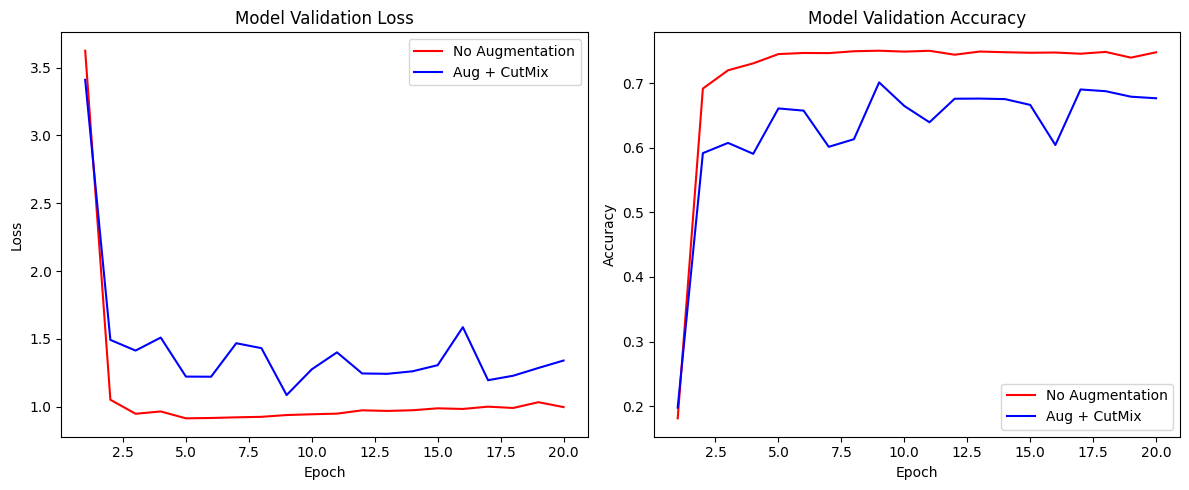

In [ ]:
import pickle
import matplotlib.pyplot as plt

with open('data/epoch20/history_resnet50_no_aug.pickle', 'rb') as file:
    history = pickle.load(file)
no_aug_val_loss = history['val_loss']
no_aug_val_acc = history['val_accuracy']

epochs = range(1, len(no_aug_val_loss) + 1)

with open('data/epoch20/history_resnet50_aug_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
aug_cutmix_val_loss = history['val_loss']
aug_cutmix_val_acc = history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, no_aug_val_loss, 'r', label='No Augmentation')
plt.plot(epochs, aug_cutmix_val_loss, 'b', label='Aug + CutMix')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(epochs, no_aug_val_acc, 'r', label='No Augmentation')
plt.plot(epochs, aug_cutmix_val_acc, 'b', label='Aug + CutMix')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

**어그멘테이션을 적용하지 않은 모델**과 **기본적인 어그멘테이션 + CutMix를 사용한 모델**을 비교한 결과입니다.  


Validation Loss
- 검증 손실이 떨어지다가 다시 올라가기 시작하면 과적합이라고 판단할 수 있는데, **어그멘테이션을 적용하지 않은 모델**은 **에포크 5쯤 이후부터 계속해서 검증 손실이 증가**하는 것을 확인할 수 있습니다.
- 반면에 **기본적인 어그멘테이션 + CutMix를 사용한 모델**은 규제 방식을 사용했을 때처럼 **검증 손실이 일정한 범위 안에서 오르내리는 것**을 확인할 수 있습니다. 아직 모델의 과적합이 진행되지 않은 것 같습니다.


Validation Accuracy
- CutMix 논문에선 분명히 CutMix 방식을 사용하면 모델의 성능이 사용하지 않은 것보다 증가한다고 하였습니다. 하지만 정확도 그래프를 확인해보면 **어그멘테이션을 적용하지 않은 모델이 더 정확도가 높다**는 것을 확인할 수 있습니다.


일단 다른 모델의 경우는 어떤지 살펴보겠습니다.

### 5. Augmentation에 의한 모델 성능 비교

#### 20 에포크

In [ ]:
# 기본 Augmentation
num_classes = ds_info.features["label"].num_classes
aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
import pickle

EPOCH = 20

aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug = aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch20/history_aug.pickle', 'wb') as file:
    pickle.dump(history_aug.history, file)

In [ ]:
# 기본 + Mixup
num_classes = ds_info.features["label"].num_classes
aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
EPOCH = 20

aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_mixup = aug_mixup.fit(
    ds_train_aug_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch20/history_aug_mixup.pickle', 'wb') as file:
    pickle.dump(history_aug_mixup.history, file)

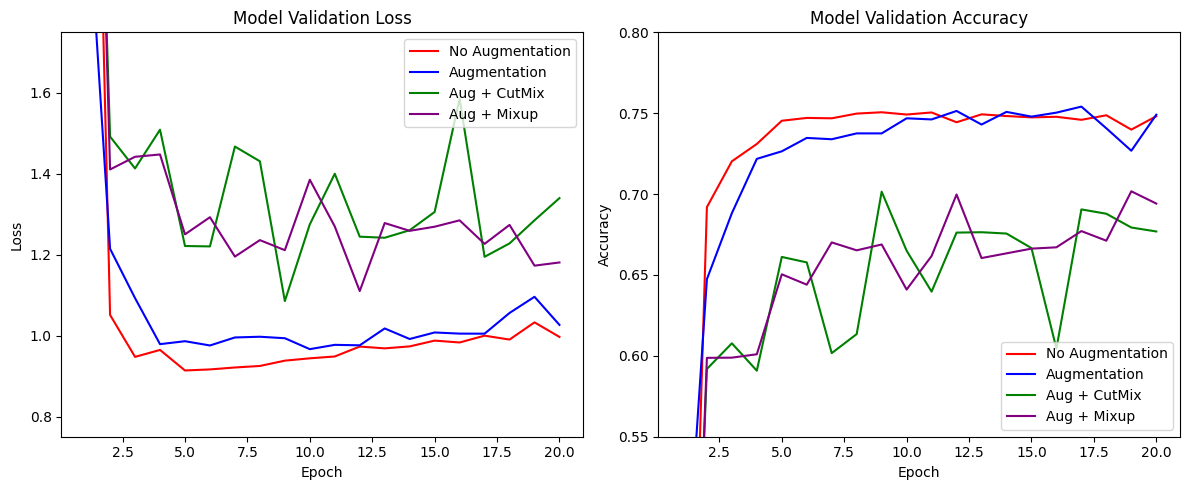

In [ ]:
# 결과 시각화
import pickle
import matplotlib.pyplot as plt

with open('data/epoch20/history_resnet50_no_aug.pickle', 'rb') as file:
    history = pickle.load(file)
no_aug_val_loss = history['val_loss']
no_aug_val_acc = history['val_accuracy']

epochs = range(1, len(no_aug_val_loss) + 1)

with open('data/epoch20/history_aug.pickle', 'rb') as file:
    history = pickle.load(file)
aug_val_loss = history['val_loss']
aug_val_acc = history['val_accuracy']

with open('data/epoch20/history_resnet50_aug_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
aug_cutmix_val_loss = history['val_loss']
aug_cutmix_val_acc = history['val_accuracy']

with open('data/epoch20/history_aug_mixup.pickle', 'rb') as file:
    history = pickle.load(file)
aug_mixup_val_loss = history['val_loss']
aug_mixup_val_acc = history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, no_aug_val_loss, 'r', label='No Augmentation')
plt.plot(epochs, aug_val_loss, 'b', label='Augmentation')
plt.plot(epochs, aug_cutmix_val_loss, 'g', label='Aug + CutMix')
plt.plot(epochs, aug_mixup_val_loss, 'purple', label='Aug + Mixup')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0.75, 1.75)

plt.subplot(1, 2, 2)
plt.plot(epochs, no_aug_val_acc, 'r', label='No Augmentation')
plt.plot(epochs, aug_val_acc, 'b', label='Augmentation')
plt.plot(epochs, aug_cutmix_val_acc, 'g', label='Aug + CutMix')
plt.plot(epochs, aug_mixup_val_acc, 'purple', label='Aug + Mixup')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.55, 0.80)

plt.tight_layout()
plt.show()

**어그멘테이션을 적용하지 않은 모델**, **기본적인 어그멘테이션을 적용한 모델**, **기본 어그멘테이션 + CutMix를 적용한 모델**, **기본 어그멘테이션 + Mixup을 적용한 모델**의 결과입니다.


Validation Loss
- **어그멘테이션을 사용하지 않은 모델**은 **5 에포크 쯤부터 과적합**이 일어난 것 같습니다.
- **기본적인 어그멘테이션을 적용한 모델**도 **10 에포크를 넘어가면서부터 과적합**이 일어난 것 같습니다.
- 반면 **기본 + CutMix 모델**은 **과적합인지 애매**한 것 같습니다. 마지막 부분에서 검증 손실이 증가하기는 하지만 앞부분의 양상을 고려하면 이 또한 일시적인 상승일 수 있기 때문입니다.
- **기본 + Mixup 모델**은 **과적합이 일어나지 않은** 것 같습니다. 지속적으로 손실이 줄어들고 있는 모양새입니다.


Validation Accuracy
- **10 에포크 쯤을 기준**으로 **어그멘테이션을 사용한 모델**이 **적용하지 않은 모델**보다 **정확도가 더 높아지기 시작**한 것을 확인할 수 있습니다. 하지만 이 또한 마지막에 주춤하면서 정확히 성능이 더 뛰어나졌는지는 장담할 수 없습니다.
- 앞서 확인했던 결과와 마찬가지로 **CutMix, Mixup을 사용한 모델들**의 결과가 **다른 모델들보다 정확도가 더 떨어지는 것을 확인**할 수 있습니다.


하지만 Mixup의 검증 손실 그래프를 보면 알 수 있듯이 **아직 과적합이 일어나지 않았기 때문에 성능 향상의 여지가 더 있을 수 있다**고 판단했습니다.  


에포크를 20에서 30으로 늘려서 테스트 해봅시다.

이 아래로는 코랩 일일 GPU 리소스를 모두 소진하여 다른 코랩 계정 + LMS로 실험하여 기록이 없습니다..

#### 30 에포크

In [ ]:
# augmentation 미사용 모델
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# No Augmentation
import pickle

EPOCH = 30

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_resnet50_no_aug.pickle', 'wb') as file:
    pickle.dump(history_resnet50_no_aug.history, file)

In [ ]:
# 기본 Augmentation
num_classes = ds_info.features["label"].num_classes
aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
import pickle

EPOCH = 30

aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug = aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_aug.pickle', 'wb') as file:
    pickle.dump(history_aug.history, file)

In [ ]:
# augmentation 사용 모델
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 + CutMix 적용
import pickle

EPOCH = 30

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_resnet50_aug_cutmix.pickle', 'wb') as file:
    pickle.dump(history_resnet50_aug_cutmix.history, file)

In [ ]:
# 기본 + Mixup
num_classes = ds_info.features["label"].num_classes
aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
EPOCH = 30

aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_mixup = aug_mixup.fit(
    ds_train_aug_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_aug_mixup.pickle', 'wb') as file:
    pickle.dump(history_aug_mixup.history, file)

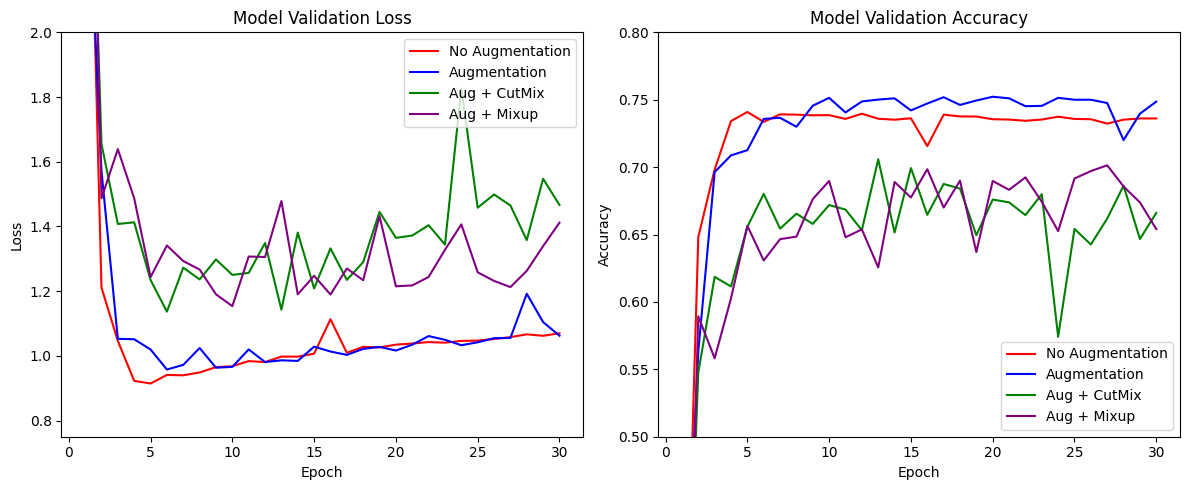

In [ ]:
# 결과 시각화
import pickle
import matplotlib.pyplot as plt

with open('data/epoch30/history_resnet50_no_aug.pickle', 'rb') as file:
    history = pickle.load(file)
no_aug_val_loss = history['val_loss']
no_aug_val_acc = history['val_accuracy']

epochs = range(1, len(no_aug_val_loss) + 1)

with open('data/epoch30/history_aug.pickle', 'rb') as file:
    history = pickle.load(file)
aug_val_loss = history['val_loss']
aug_val_acc = history['val_accuracy']

with open('data/epoch30/history_resnet50_aug_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
aug_cutmix_val_loss = history['val_loss']
aug_cutmix_val_acc = history['val_accuracy']

with open('data/epoch30/history_aug_mixup.pickle', 'rb') as file:
    history = pickle.load(file)
aug_mixup_val_loss = history['val_loss']
aug_mixup_val_acc = history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, no_aug_val_loss, 'r', label='No Augmentation')
plt.plot(epochs, aug_val_loss, 'b', label='Augmentation')
plt.plot(epochs, aug_cutmix_val_loss, 'g', label='Aug + CutMix')
plt.plot(epochs, aug_mixup_val_loss, 'purple', label='Aug + Mixup')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0.75, 2.0)

plt.subplot(1, 2, 2)
plt.plot(epochs, no_aug_val_acc, 'r', label='No Augmentation')
plt.plot(epochs, aug_val_acc, 'b', label='Augmentation')
plt.plot(epochs, aug_cutmix_val_acc, 'g', label='Aug + CutMix')
plt.plot(epochs, aug_mixup_val_acc, 'purple', label='Aug + Mixup')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.50, 0.80)

plt.tight_layout()
plt.show()

...30 에포크 실험 결과입니다.  


**Mixup**의 그래프는 크게 요동치고 있지만 전체적으로 **천천히 성능의 개선**이 이루어지고 있는 것 같습니다...만


어째서 CutMix는 검증 손실이 점점 증가하고 정확도는 떨어지고 있는 걸까요?  
일단 시간이 별로 없지만 한 가지 아이디어로 기본 어그멘테이션 방법과 혼용해서 이런 일이 생긴 것이 아닐까 추측을 해봤습니다. 즉, **어그멘테이션 기법을 너무 과하게 사용하여 노이즈가 데이터셋에서 가지는 중요도가 너무 커져버린 것은 아닌지** 싶었습니다.  
한 번 기본 어그멘테이션 기법을 제거하고 CutMix만을 적용하여 30 에포크 훈련을 진행 해보겠습니다.

#### 기본 + CutMix vs CutMix Only

In [ ]:
ds_train_cutmix = apply_normalizer_on_dataset(ds_train, with_cutmix=True)    # CutMix 적용

In [ ]:
# augmentation 사용 모델
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# CutMix 적용
import pickle

EPOCH = 30

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = aug_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_resnet50_cutmix.pickle', 'wb') as file:
    pickle.dump(history_resnet50_cutmix.history, file)

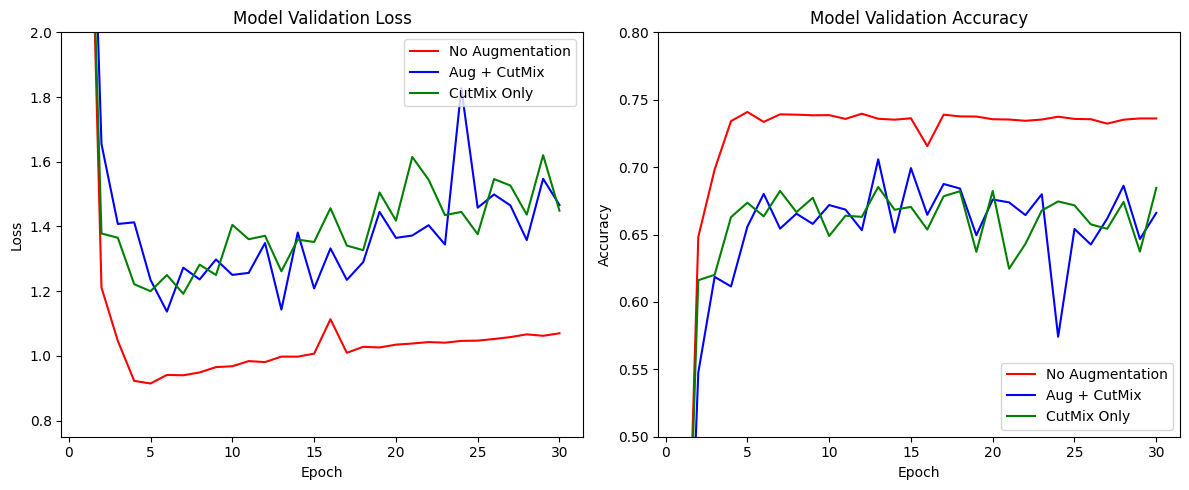

In [9]:
# 결과 시각화
import pickle
import matplotlib.pyplot as plt

with open('data/epoch30/history_resnet50_no_aug.pickle', 'rb') as file:
    history = pickle.load(file)
no_aug_val_loss = history['val_loss']
no_aug_val_acc = history['val_accuracy']

epochs = range(1, len(no_aug_val_loss) + 1)

with open('data/epoch30/history_resnet50_aug_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
aug_cutmix_val_loss = history['val_loss']
aug_cutmix_val_acc = history['val_accuracy']

with open('data/epoch30/history_resnet50_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
cutmix_val_loss = history['val_loss']
cutmix_val_acc = history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, no_aug_val_loss, 'r', label='No Augmentation')
plt.plot(epochs, aug_cutmix_val_loss, 'b', label='Aug + CutMix')
plt.plot(epochs, cutmix_val_loss, 'g', label='CutMix Only')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0.75, 2.0)

plt.subplot(1, 2, 2)
plt.plot(epochs, no_aug_val_acc, 'r', label='No Augmentation')
plt.plot(epochs, aug_cutmix_val_acc, 'b', label='Aug + CutMix')
plt.plot(epochs, cutmix_val_acc, 'g', label='CutMix Only')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.50, 0.80)

plt.tight_layout()
plt.show()

**CutMix만 사용한 모델**과 **기본 어그멘테이션 + CutMix 모델**간의 **성능 차이는 거의 없다**는 결론입니다..  
아무래도 다른 것이 문제인 것 같습니다.  


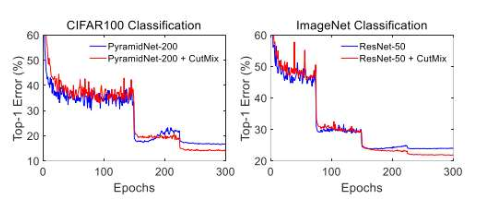  
논문에선 기존 ResNet은 150 에포크 이후로 과적합이 일어나지만 CutMix는 꾸준히 성능 향상이 일어나고 있는 것을 확인할 수 있습니다.  
왜 이런 결과가 생기는 걸까요?

혹시 CutMix함수에서 잘라내는 영역의 비율을 교체한다면 어떻게 될까요?  
너무 **이미지를 크게 잘라내서 이도저도 아닌 이미지가 생겨난 것이 아닐까**요?  
get_clip_box()함수를 수정해서 잘라내는 영역의 비율을 기존 (0, 이미지 사이즈)범위에서 (0, 이미지 사이즈 * 0.8)로 줄여보겠습니다.

아래로는 구글 드라이브 일일 GPU 사용량이 회복되어 다시 로그를 남길 수 있었습니다.

#### CutMix 함수 수정 1

In [9]:
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # image_size 앞에 0.8을 곱했습니다.
    width = tf.cast(0.8 * image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(0.8 * image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)

    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)

    return x_min, y_min, x_max, y_max

In [10]:
ds_train_aug_modified_cutmix = apply_normalizer_on_dataset(ds_train, with_aug=True, with_cutmix=True)    # CutMix 적용

In [11]:
# augmentation 사용 모델
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 1s 0us/step


In [12]:
# 기본 + CutMix 적용, CutMix함수 수정
import pickle

EPOCH = 30

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_modified_cutmix = aug_resnet50.fit(
    ds_train_aug_modified_cutmix, # 기본 + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_aug_modified_cutmix.pickle', 'wb') as file:
    pickle.dump(history_aug_modified_cutmix.history, file)

Epoch 1/30
750/750 [==============================] - 195s 210ms/step - loss: 3.5728 - accuracy: 0.2585 - val_loss: 2.8692 - val_accuracy: 0.2868
Epoch 2/30
750/750 [==============================] - 163s 218ms/step - loss: 2.6749 - accuracy: 0.4803 - val_loss: 1.3495 - val_accuracy: 0.6192
Epoch 3/30
750/750 [==============================] - 177s 236ms/step - loss: 2.3922 - accuracy: 0.5703 - val_loss: 1.5389 - val_accuracy: 0.5847
Epoch 4/30
750/750 [==============================] - 177s 235ms/step - loss: 2.1959 - accuracy: 0.6422 - val_loss: 1.2079 - val_accuracy: 0.6704
Epoch 5/30
750/750 [==============================] - 176s 235ms/step - loss: 2.0669 - accuracy: 0.6906 - val_loss: 1.1628 - val_accuracy: 0.6743
Epoch 6/30
750/750 [==============================] - 164s 219ms/step - loss: 1.9483 - accuracy: 0.7289 - val_loss: 1.1294 - val_accuracy: 0.6834
Epoch 7/30
750/750 [==============================] - 178s 237ms/step - loss: 1.8719 - accuracy: 0.7582 - val_loss: 1.1152 -

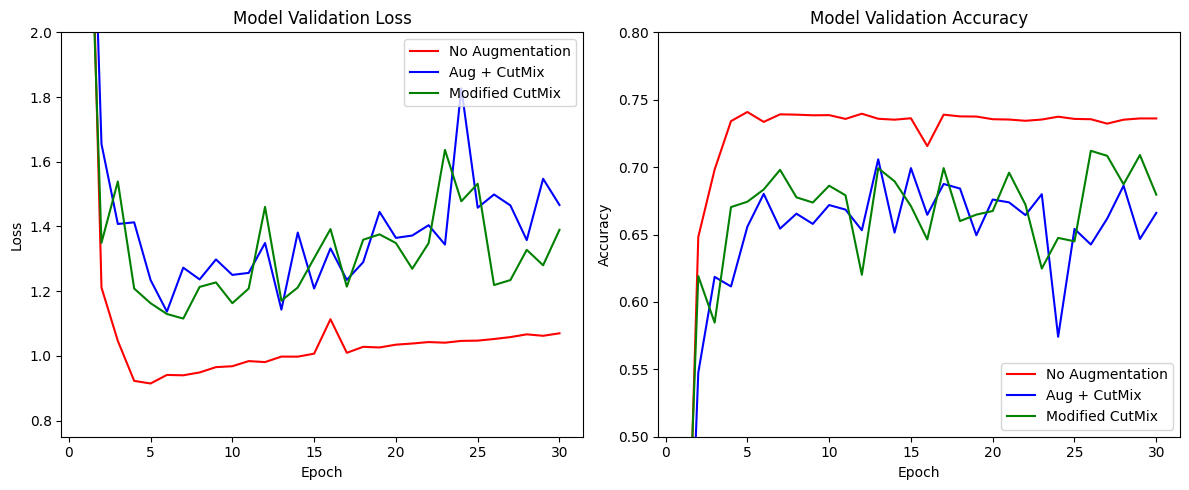

In [13]:
# 결과 시각화
import pickle
import matplotlib.pyplot as plt

with open('data/epoch30/history_resnet50_no_aug.pickle', 'rb') as file:
    history = pickle.load(file)
no_aug_val_loss = history['val_loss']
no_aug_val_acc = history['val_accuracy']

epochs = range(1, len(no_aug_val_loss) + 1)

with open('data/epoch30/history_resnet50_aug_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
aug_cutmix_val_loss = history['val_loss']
aug_cutmix_val_acc = history['val_accuracy']

with open('data/epoch30/history_aug_modified_cutmix.pickle', 'rb') as file:
    history = pickle.load(file)
modified_cutmix_val_loss = history['val_loss']
modified_cutmix_val_acc = history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, no_aug_val_loss, 'r', label='No Augmentation')
plt.plot(epochs, aug_cutmix_val_loss, 'b', label='Aug + CutMix')
plt.plot(epochs, modified_cutmix_val_loss, 'g', label='Modified CutMix')
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0.75, 2.0)

plt.subplot(1, 2, 2)
plt.plot(epochs, no_aug_val_acc, 'r', label='No Augmentation')
plt.plot(epochs, aug_cutmix_val_acc, 'b', label='Aug + CutMix')
plt.plot(epochs, modified_cutmix_val_acc, 'g', label='Modified CutMix')
plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.50, 0.80)

plt.tight_layout()
plt.show()

아주 약간의 성능 향상이 있는 것 같습니다.  
이미지 선택 영역의 넓이가 훈련에 영향을 미친다고 가정을 해봅시다.

원본 이미지 영역에서 잘라내는 비율을 원본 이미지 넓이의 1/2이 넘지 않도록 제한하는 것은 어떨까요?  

원본 이미지의 넓이가 A 라면
0.5 * A > x * y  
여기서 가로 x를 랜덤으로 설정한다면, 0.5 * A /x > y가 되는 값을 랜덤하게 설정해보겠습니다.

#### CutMix 함수 수정 2

In [ ]:
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    image_area = image_size_x * image_size_y

    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    width = tf.cast(image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    # 세로를 가로크기와 원본 이미지 넓이에 맞춰 유동적으로 설정합니다.
    height = tf.cast(tf.random.uniform([], 0, tf.cast(
        0.5 * image_area / tf.cast(width, tf.float32), tf.float32)), tf.int32)

    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + height // 2)

    return x_min, y_min, x_max, y_max

In [ ]:
ds_train_aug_modified_cutmix2 = apply_normalizer_on_dataset(ds_train, with_aug=True, with_cutmix=True)    # CutMix 적용

In [ ]:
# augmentation 사용 모델
num_classes = ds_info.features["label"].num_classes
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# 기본 + CutMix 적용, CutMix함수 수정
import pickle

EPOCH = 30

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_modified_cutmix2 = aug_resnet50.fit(
    ds_train_aug_modified_cutmix2, # 기본 + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

with open('data/epoch30/history_aug_modified_cutmix2.pickle', 'wb') as file:
    pickle.dump(history_aug_modified_cutmix2.history, file)

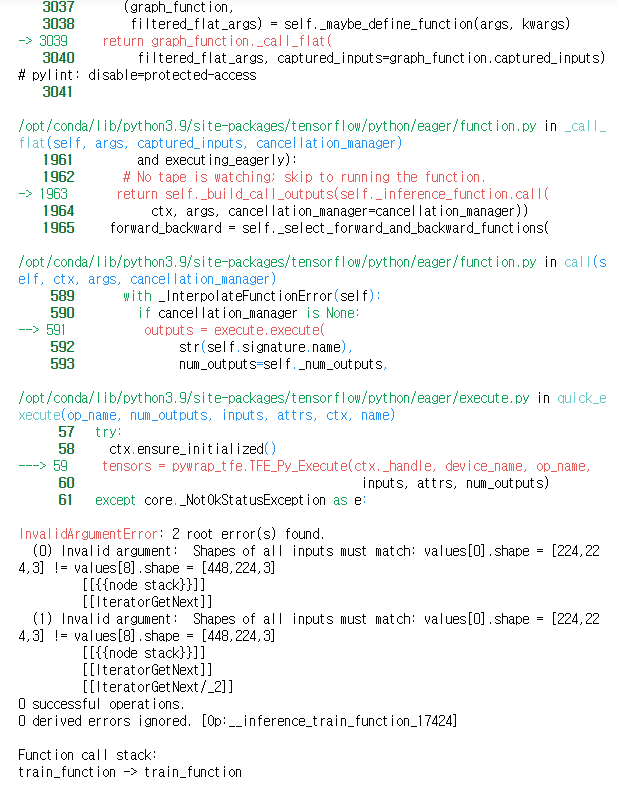

에러가 납니다..ㅋㅋㅋ  
분명 max_x, max_y, min_x, min_y를 설정할 때 tf.math.minimum, tf.math.maximum 함수를 사용하여 구하기 때문에 height의 값은 어떤 값이 나와도 상관 없을 것이라 생각했는데 아니었나봅니다..

### 6. 결론

실험 결과
- **어그멘테이션 기법을 사용**하면 사용하지 않을 때보다 **일반적으로 성능이 더 향상**됨을 알 수 있습니다.
- **Mixup 기법**을 사용하면 규제를 사용할 때와 비슷한 효과를 얻어 **쉽게 과적합되지 않고 계속해서 성능이 향상**되는 것을 확인할 수 있었습니다.
- CutMix 기법을 사용하면 원래는 성능 향상이 있어야 하지만 뭔가 문제(?)가 있는 것 같습니다.
    - **첫 번째 실험**으로 너무 과한 어그멘테이션을 수행했다고 생각하여 **기본 어그멘테이션을 제외하고 CutMix만을 사용**하였지만 **차이는 없었습니다.**
    - **두 번째 실험**으로 CutMix가 수행되는 과정에서 랜덤한 크기로 선택되는 patch 영역의 크기가 너무 커서 이미지에서 특성을 표현하는 부분이 많이 사라졌다고 생각을 했습니다. 따라서 **patch 영역의 가로세로 크기를 0.8배로 줄여**보았더니 **약간의 성능 향상**이 있었습니다.
    - **세 번째 실험**으로 앞선 두 번째 실험의 내용을 바탕으로 patch 영역의 최대 넓이가 원본 이미지의 넓이의 1/2이 넘지 않도록 실험을 진행...하려 했으나 오류가 나서 더이상 진행하지 못했습니다.


추가로 알게된 점
- sparse categorical crossentropy가 아닌 categorical crossentropy를 사용해야 한다는 점 (원래 정수형으로 원 핫 인코딩 되어있던 라벨이 실수형 멀티 핫 인코딩 형식으로 변경되엇기 때문에 이를 지키지 않으면 차원 오류가 발생하였습니다.)
- CutMix의 성능 저하에 있어서 이미지에서 잘라낼 영역의 크기를 설정하는 것이 실마리가 될지도 모른다는 점